In [12]:
# manipulation des données
import numpy as np
import pandas as pd

# matplotlib et seaborn pour les représentations graphiques
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.utils import to_categorical

# Gestion du système de fichiers
import os
from os import listdir

# Suppression des alertes
import warnings
warnings.filterwarnings('ignore')

In [13]:
data = pd.read_csv('../Data/5.augmented_dataset.csv')
path = '../Data/AugmentedImages/'
data

,image_path,label
0,5eec66ec172ce096cd4e5c947686b56a.jpg,0
1,ffc2e1fc7c886ec09a331040ada038aa.jpg,4
2,AI6c3768639e82ceaeab681e083b897672.jpg,2
3,AId98fac46793639eceaaa2e74cadd4973.jpg,6
4,6e812fbc03331ab363789b0f2d6b3ff2.jpg,0
...,...,...
2095,AIa3dea07b2f7bf48276d32513091be717.jpg,5
2096,AId47f1cb78db4a23e2516e2d34da34c8a.jpg,5
2097,AI1afa5f2c3c9b4b43def6dc2e695d2c87.jpg,5
2098,AIace154420a51fad090b3543995630051.jpg,4


In [14]:
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


Nous chargeons l'image au format 224x224 pixels pour faciliter son traitement, puis nous la convertissons en un tableau NumPy.  
L'ajout de dimension à notre array permet de créer un lot d'image que nous utiliserons dans notre réseau de neuronnes.  
`preprocess_input()` est un traitement propre au réseau de neuronne VGG16 qui permettra d'alimenter le modèle en images correctement paramtrées.

In [15]:
def preprocess_image(image_file):
    image = load_img(path+image_file, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    return image

Nous appliquons notre traitement de l'image à chaque image de notre Dataframe et scindons les données en données d'entrainement et de validation.

In [16]:
X = np.vstack([preprocess_image(image_file) for image_file in data['image_path']])
y = to_categorical(data['label'])
#y = data['label'] c'est la même chose

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Nous utilisons ensuite le modèle VGG16 en utilisant les poids pré-entrainés sur la base de données `Imagenet`.
Nous ne mettons pas à jour les couches du réseau de neurones avec `layer.trainable = False`

In [17]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint("./best_model.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [19]:
history = model.fit(X_train, y_train, epochs=4, batch_size=50, validation_data=(X_test, y_test))

Epoch 1/4
34/34 [==============================] - 327s 10s/step - loss: 13.8300 - accuracy: 0.6976 - val_loss: 2.6183 - val_accuracy: 0.7833
Epoch 2/4
34/34 [==============================] - 305s 9s/step - loss: 0.4783 - accuracy: 0.9357 - val_loss: 1.6063 - val_accuracy: 0.8524
Epoch 3/4
34/34 [==============================] - 296s 9s/step - loss: 0.0895 - accuracy: 0.9815 - val_loss: 1.6057 - val_accuracy: 0.8500
Epoch 4/4
34/34 [==============================] - 298s 9s/step - loss: 0.0055 - accuracy: 0.9976 - val_loss: 1.6212 - val_accuracy: 0.8667


In [22]:
score = model.evaluate(X_test, y_test, verbose=0)

print('Test loss    :', score[0])
print('Test accuracy:', score[1])# mean absolute error ?????

Test loss    : 1.6212416887283325
Test accuracy: 0.8666666746139526


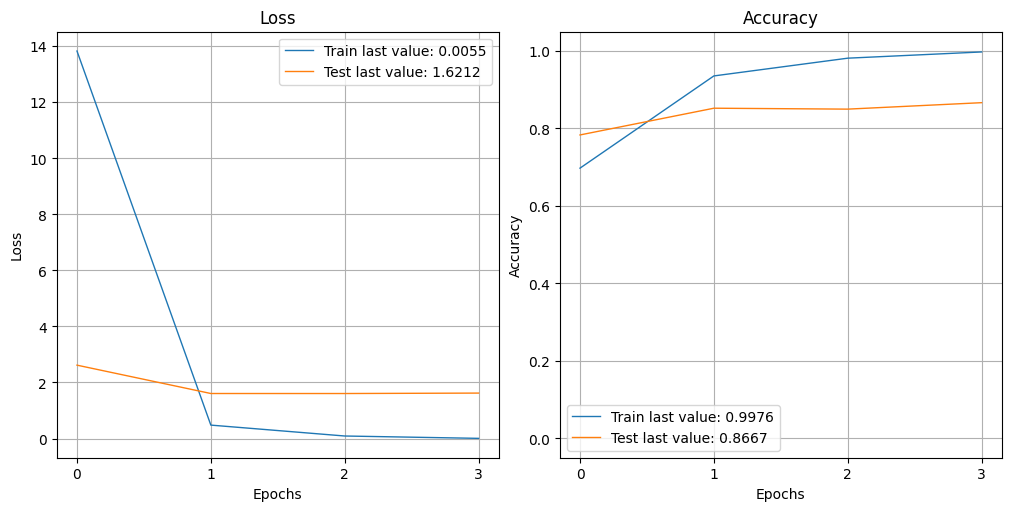

In [24]:
from plot_keras_history import show_history
import matplotlib.pyplot as plt

show_history(history)
plt.close()